<a href="https://colab.research.google.com/github/jaicdev/Notebooks/blob/main/UNETS_Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

UNET is a convolutional neural network (CNN) architecture designed for image segmentation, especially in medical image analysis. Introduced in 2015, it has since been applied in diverse fields like computer vision and remote sensing. The name "UNET" comes from its U-shaped structure, featuring an encoder-decoder framework with skip connections for efficient pixel-wise segmentation while preserving spatial details.

1. **Encoder:**
   - Comprising convolutional layers, it progressively reduces input image dimensions, capturing high-level features and semantic information.
   - Max-pooling operations downsample feature maps, reducing computation and expanding the receptive field.

2. **Bottleneck:**
   - Acts as a bridge between the encoder and decoder, further abstracting features for better representation.

3. **Decoder:**
   - Counterpart to the encoder, it uses transposed convolutional layers to increase spatial resolution.
   - Skip connections link corresponding encoder and decoder layers, preserving low-level spatial details.

4. **Output Layer:**
   - Final layer uses a sigmoid activation for pixel-wise segmentation masks, especially in binary tasks like object vs. background.

UNET excels in various segmentation tasks, offering precise predictions with its unique features. Its skip connections capture local and global context, and its symmetric architecture promotes feature map symmetry. Notably, UNET performs well with limited training data, leveraging skip connections for feature reuse and facilitating transfer learning. Researchers have extended UNET for specific applications, solidifying its role in advancing deep learning for image segmentation.

The UNET architecture has been trained and tested using the dataset available at the following Kaggle link: [Electron Microscopy Particle Segmentation Dataset](https://www.kaggle.com/datasets/batuhanyil/electron-microscopy-particle-segmentation).

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!unzip '/content/archive.zip' -d '/content/EMP'

Import Necessary Libraries


In [ ]:
import os
import torch
import random
import numpy as np
import pandas as pd
import seaborn as sn
import torch.nn as nn
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
import torchvision.transforms as T
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from sklearn.metrics import jaccard_score
from torch.utils.data import random_split
import torchvision.transforms.functional as TF
from torch.utils.tensorboard import SummaryWriter

In [ ]:
# Set the random seed for reproducibility
seed = 42
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

In [ ]:
# set device to cuda if available, otherwise to cpu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


UNET Architecture


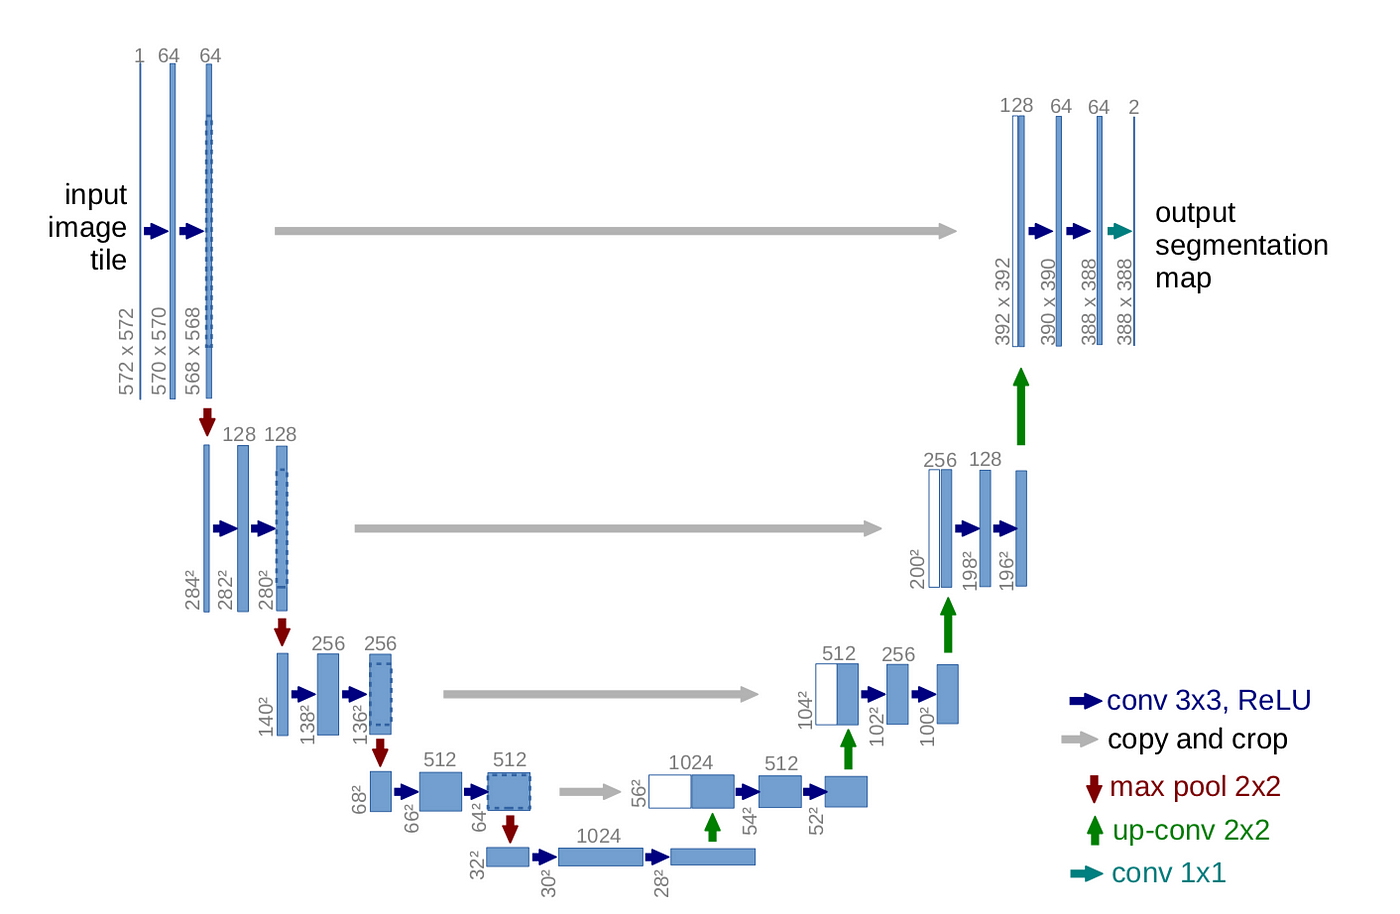


In [ ]:
class DoubleConv(nn.Module):
    """
    A class representing the double convolutional block used in the UNet architecture.

    Attributes:
    in_channels (int): The number of input channels.
    out_channels (int): The number of output channels.
    """
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True))

    def forward(self, x):
        """
        Defines the forward pass of the double convolutional block.

        Args:
        x (tensor): The input tensor.

        Returns:
        tensor: The output tensor.
        """
        return self.conv(x)

class UNET(nn.Module):
    """
    A class representing the UNet architecture for semantic segmentation.

    Attributes:
    in_channels (int): The number of input channels.
    out_channels (int): The number of output channels.
    features (list): A list of the number of features in each layer of the encoder/decoder.
    """
    def __init__(self, in_channels=3, out_channels=1, features=[64, 128, 256, 512]):
        super(UNET, self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Down part of UNet
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # Up part of UNet
        for feature in reversed(features):
            self.ups.append(nn.ConvTranspose2d(feature * 2, feature, kernel_size=2, stride=2))
            self.ups.append(DoubleConv(feature * 2, feature))

        self.bottleneck = DoubleConv(features[-1], features[-1] * 2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        """
        Defines the forward pass of the UNet architecture.

        Args:
        x (tensor): The input tensor.

        Returns:
        tensor: The output tensor.
        """
        skip_connections = []

        # Down part of UNet
        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        # Up part of UNet
        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx // 2]

            # Ensure the spatial dimensions of the tensors match
            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[2:],antialias=None)

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx + 1](concat_skip)

        return self.final_conv(x)

In [ ]:
#Testing the input and output parameters of the UNET
def test():
    x = torch.randn((3,1,224,224))
    model = UNET(in_channels=1,out_channels=1)
    preds = model(x)
    print(preds.shape)
    print(x.shape)
    assert preds.shape == x.shape

if __name__ == '__main__':
    test()

torch.Size([3, 1, 224, 224])
torch.Size([3, 1, 224, 224])


Preparation of Dataset for dataloaders.

In [ ]:
class EMPDataset(Dataset):
    def __init__(self, root_dir, mask_transforms=None, img_transforms=None):
        """
        Args:
            root_dir (string): Directory with all the images and masks.
            transforms (callable, optional): Optional transforms to be applied on a sample.
        """
        self.root_dir = root_dir
        self.mask_transforms = mask_transforms
        self.img_transforms = img_transforms
        self.img_dir = os.path.join(root_dir, "images")
        self.mask_dir = os.path.join(root_dir, "segmaps")
        self.file_names = os.listdir(self.mask_dir)
        self.mask_paths = [os.path.join(self.mask_dir, mask_name) for mask_name in self.file_names]
        self.img_paths = [os.path.join(self.img_dir, img_name) for img_name in self.file_names]

    def __len__(self):
        """
        Returns:
            the number of samples in the dataset
        """
        return len(self.file_names)

    def __getitem__(self, idx):
        """
        Args:
            idx (int): Index of sample to get.

        Returns:
            A tuple (image, mask).
        """
        mask_path, img_path = self.mask_paths[idx], self.img_paths[idx]
        mask, img = Image.open(mask_path), Image.open(img_path).convert('RGB')

        # Apply transforms on the image and mask if available
        if self.img_transforms is not None:
          img = self.img_transforms(img)

        if self.mask_transforms is not None:
          mask = self.mask_transforms(mask)

        # Convert mask to binary with values {0, 1}
        mask = torch.as_tensor(mask, dtype=torch.float32)
        mask[mask > 0] = 1

        # Convert image to float tensor
        img = torch.as_tensor(img, dtype=torch.float32)

        return img, mask

In [ ]:
# Define image transformations
img_transforms = T.Compose([
    T.ToTensor(),   # Convert the image to tensor
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # Normalize the image with pre-computed mean and standard deviation
    T.Resize((244, 244),antialias=None),   # Resize the image to (244, 244)
])

# Define mask transformations
mask_transforms = T.Compose([
    T.ToTensor(),   # Convert the mask to tensor
    T.Resize((244, 244),antialias=None)   # Resize the mask to (244, 244)
])


In [ ]:
dataset = EMPDataset(
root_dir='/content/drive/MyDrive/UNET_Tutorial/EMP',
img_transforms=img_transforms,
mask_transforms=mask_transforms
)

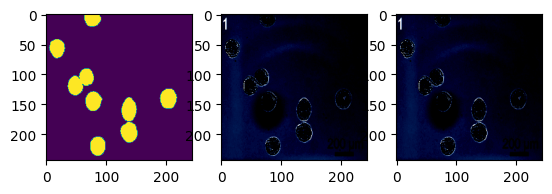

In [ ]:
# Load a single image and mask from the dataset
mask, img = dataset[200]

# Create a figure with two subplots, one for the image and one for the mask
fig, ax = plt.subplots(nrows=1, ncols=3)

# Display the image in the first subplot
pos1 = ax[0].imshow(img.permute((1, 2, 0)))

# Display the mask in the second subplot
pos2 = ax[1].imshow(mask.permute((1, 2, 0)))

# Display the mask in the third subplot
pos2 = ax[2].imshow(mask.permute((1, 2, 0)))


In [ ]:
# Split the dataset into training and validation sets
# using random_split function from torch.utils.data module
dataset_train, dataset_val = random_split(dataset, [int(0.8 * len(dataset)), len(dataset) - int(0.8 * len(dataset))])

# Print the length of training and validation datasets
print(f"Number of training samples: {len(dataset_train)}")
print(f"Number of validation samples: {len(dataset_val)}")


Number of training samples: 372
Number of validation samples: 93


In [ ]:
dataloader_train = DataLoader(dataset_train, batch_size=8)
dataloader_val = DataLoader(dataset_val, batch_size=8)

In [ ]:
# create an instance of the UNET model and send it to the device
model = UNET(in_channels=3,out_channels=1).to(device)
#print model
print(model)
# define the loss function
criterion = nn.BCEWithLogitsLoss()

# define the optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001)


UNET(
  (ups): ModuleList(
    (0): ConvTranspose2d(1024, 512, kernel_size=(2, 2), stride=(2, 2))
    (1): DoubleConv(
      (conv): Sequential(
        (0): Conv2d(1024, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
    (2): ConvTranspose2d(512, 256, kernel_size=(2, 2), stride=(2, 2))
    (3): DoubleConv(
      (conv): Sequential(
        (0): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), p

In [ ]:

# define the function for training the model
def train(model, dataloader):
    # set the model to training mode
    model.train()

    # initialize the training loss
    train_loss = 0

    # loop through the dataloader
    for data in tqdm(dataloader):
        # zero the gradients
        optimizer.zero_grad()

        # get the inputs and labels and send them to the device
        images, masks = data[0].to(device), data[1].to(device)

        # forward pass
        out = model(images)

        # calculate the loss
        loss = criterion(out, masks)

        # update the training loss
        train_loss += loss.item()

        # backward pass and optimize
        loss.backward()
        optimizer.step()

    # return the average training loss
    return train_loss / len(dataloader)

# define the function for testing the model
def test(model, dataloader):
    # set the model to evaluation mode
    model.eval()

    # initialize the testing loss and IoU
    test_loss = 0
    test_iou = 0

    # loop through the dataloader
    for data in tqdm(dataloader):
        # get the inputs and labels and send them to the device
        images, masks = data[0].to(device), data[1].to(device)

        # forward pass
        out = model(images)

        # calculate the loss
        loss = criterion(out, masks)

        # update the testing loss
        test_loss += loss.item()

        # calculate the IoU
        test_iou += jaccard_score(masks.detach().cpu().flatten().numpy(),
                                  out.detach().cpu().flatten().numpy() > 0.99)

    # return the average testing loss and IoU
    return test_loss / len(dataloader), test_iou / len(dataloader)

In [ ]:
def save_weights(model, optimizer, epoch, path):
    state = {'epoch': epoch, 'model_state_dict': model.state_dict(), 'optimizer_state_dict': optimizer.state_dict()}
    torch.save(state, path)


In [ ]:
best_training_loss = float('inf')  # Initialize with a very high loss
best_model_state = None

epochs = 25
train_loss_lst = []

for epoch in range(epochs):
    train_loss = train(model, dataloader_train)
    train_loss_lst.append(train_loss)

    if train_loss < best_training_loss:
        best_training_loss = train_loss
        best_model_state = model.state_dict()

    print('Epoch [{}/{}], Train loss: {:.4f}'.format(epoch + 1, epochs, train_loss))

if best_model_state is not None:
    save_path_best = '/content/best_weights.pt'
    torch.save(best_model_state, save_path_best)

100%|██████████| 47/47 [00:20<00:00,  2.25it/s]


Epoch [1/25], Train loss: 0.0659


100%|██████████| 47/47 [00:21<00:00,  2.17it/s]


Epoch [2/25], Train loss: 0.1441


100%|██████████| 47/47 [00:20<00:00,  2.24it/s]


Epoch [3/25], Train loss: 0.1110


100%|██████████| 47/47 [00:20<00:00,  2.27it/s]


Epoch [4/25], Train loss: 0.0772


100%|██████████| 47/47 [00:20<00:00,  2.25it/s]


Epoch [5/25], Train loss: 0.0670


100%|██████████| 47/47 [00:21<00:00,  2.22it/s]


Epoch [6/25], Train loss: 0.0590


100%|██████████| 47/47 [00:20<00:00,  2.25it/s]


Epoch [7/25], Train loss: 0.0544


100%|██████████| 47/47 [00:20<00:00,  2.25it/s]


Epoch [8/25], Train loss: 0.0507


100%|██████████| 47/47 [00:20<00:00,  2.25it/s]


Epoch [9/25], Train loss: 0.0484


100%|██████████| 47/47 [00:20<00:00,  2.25it/s]


Epoch [10/25], Train loss: 0.0460


100%|██████████| 47/47 [00:20<00:00,  2.25it/s]


Epoch [11/25], Train loss: 0.0439


100%|██████████| 47/47 [00:20<00:00,  2.26it/s]


Epoch [12/25], Train loss: 0.0421


100%|██████████| 47/47 [00:20<00:00,  2.25it/s]


Epoch [13/25], Train loss: 0.0404


100%|██████████| 47/47 [00:20<00:00,  2.26it/s]


Epoch [14/25], Train loss: 0.0389


100%|██████████| 47/47 [00:20<00:00,  2.25it/s]


Epoch [15/25], Train loss: 0.0377


100%|██████████| 47/47 [00:20<00:00,  2.25it/s]


Epoch [16/25], Train loss: 0.0365


100%|██████████| 47/47 [00:21<00:00,  2.24it/s]


Epoch [17/25], Train loss: 0.0357


100%|██████████| 47/47 [00:20<00:00,  2.25it/s]


Epoch [18/25], Train loss: 0.0352


100%|██████████| 47/47 [00:20<00:00,  2.25it/s]


Epoch [19/25], Train loss: 0.0355


100%|██████████| 47/47 [00:20<00:00,  2.25it/s]


Epoch [20/25], Train loss: 0.0370


100%|██████████| 47/47 [00:20<00:00,  2.25it/s]


Epoch [21/25], Train loss: 0.1048


100%|██████████| 47/47 [00:20<00:00,  2.26it/s]


Epoch [22/25], Train loss: 0.1823


100%|██████████| 47/47 [00:20<00:00,  2.25it/s]


Epoch [23/25], Train loss: 0.1139


100%|██████████| 47/47 [00:20<00:00,  2.25it/s]


Epoch [24/25], Train loss: 0.0759


100%|██████████| 47/47 [00:20<00:00,  2.24it/s]


Epoch [25/25], Train loss: 0.0586


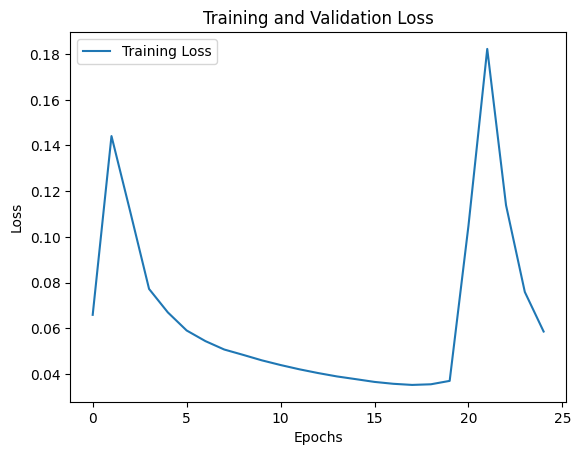

In [ ]:
plt.plot(train_loss_lst, label='Training Loss')
#plt.plot(test_loss_lst, label='Validation Loss')

plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.legend(loc='best')
plt.show()

Text(0.5, 1.0, 'Predicted Mask')

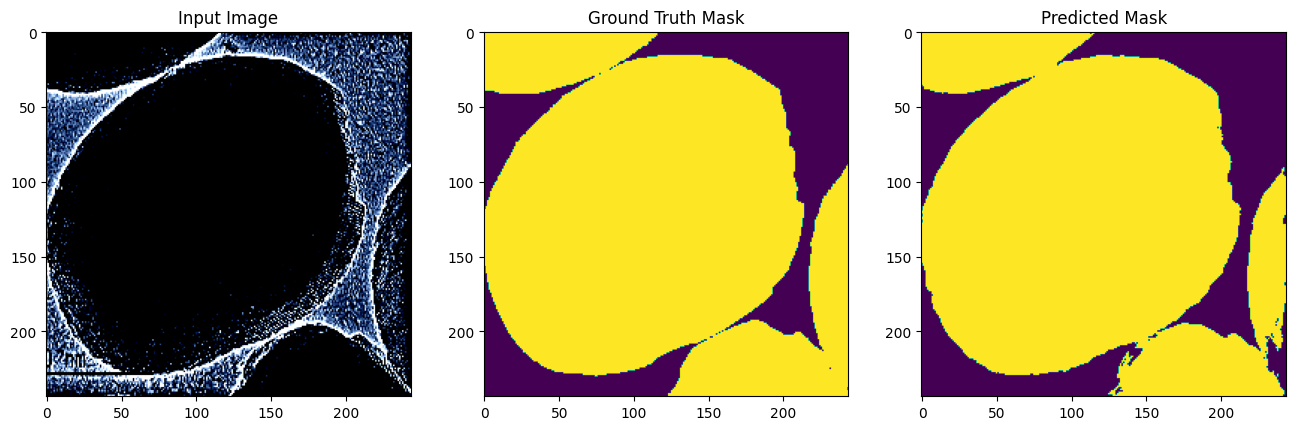

In [ ]:
# Get a batch of training data
dataiter = iter(dataloader_train)
images, masks = next(dataiter)

# Move the data to the device
images = images.to(device)

# Get the model's output for the batch
output = model(images)

# Select an image from the batch to display
image_indx = 1

# Threshold the output to get a binary mask
thresh_img = output[image_indx].cpu().detach() > 0.999

# Set up a figure to display the original image, the ground-truth mask, and the predicted mask
fig, axs = plt.subplots(1, 3, figsize=(16,9))

# Display the original image in the first subplot
axs[0].imshow(images[image_indx].cpu().permute((1, 2, 0)))
axs[0].set_title('Input Image')

# Display the ground-truth mask in the second sufrom tqdm import tqdmbplot
axs[1].imshow(masks[image_indx].cpu().permute((1, 2, 0)))
axs[1].set_title('Ground Truth Mask')
# Display the predicted mask in the third subplot
axs[2].imshow(thresh_img.permute((1, 2, 0)))
axs[2].set_title('Predicted Mask')